In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lmfit
from collections import defaultdict

from matplotlib.ticker import MultipleLocator
from lmfit import Parameter, Parameters 

import sivqed.models.fitter as fitter
from sivqed.models.cavity import Cavity, MultiQubitCavity

np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [8, 5]

In [2]:
cavity_path = "../data/2021_03_24_received_cavity-spectrometer/cavity-spectrometer/L_B_a_1_post_tune_1_1800gr_100ms_734.00nm_2.00mm.txt"
siv_path = "../data/2021_03_24_received_cavity-spectrometer/siv4/sweeper_bwd_scans_"
siv_files = ["13_41_57.txt", "13_42_43.txt", "13_43_30.txt", "13_45_05.txt", "13_45_54.txt", "13_46_44.txt", "13_47_34.txt", "13_48_22.txt", "13_49_11.txt", "13_50_00.txt"]

# Plot Cavity Data 

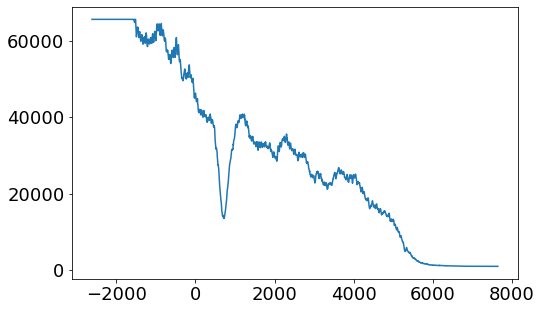

In [3]:
cavity_data = np.loadtxt(cavity_path, skiprows=2, delimiter=",")
lambdas, cavity_counts = cavity_data.T
cavity_freqs = 2.998E8 / lambdas - 406000 # GHz
plt.plot(cavity_freqs, cavity_counts)

## Plot SiV Data

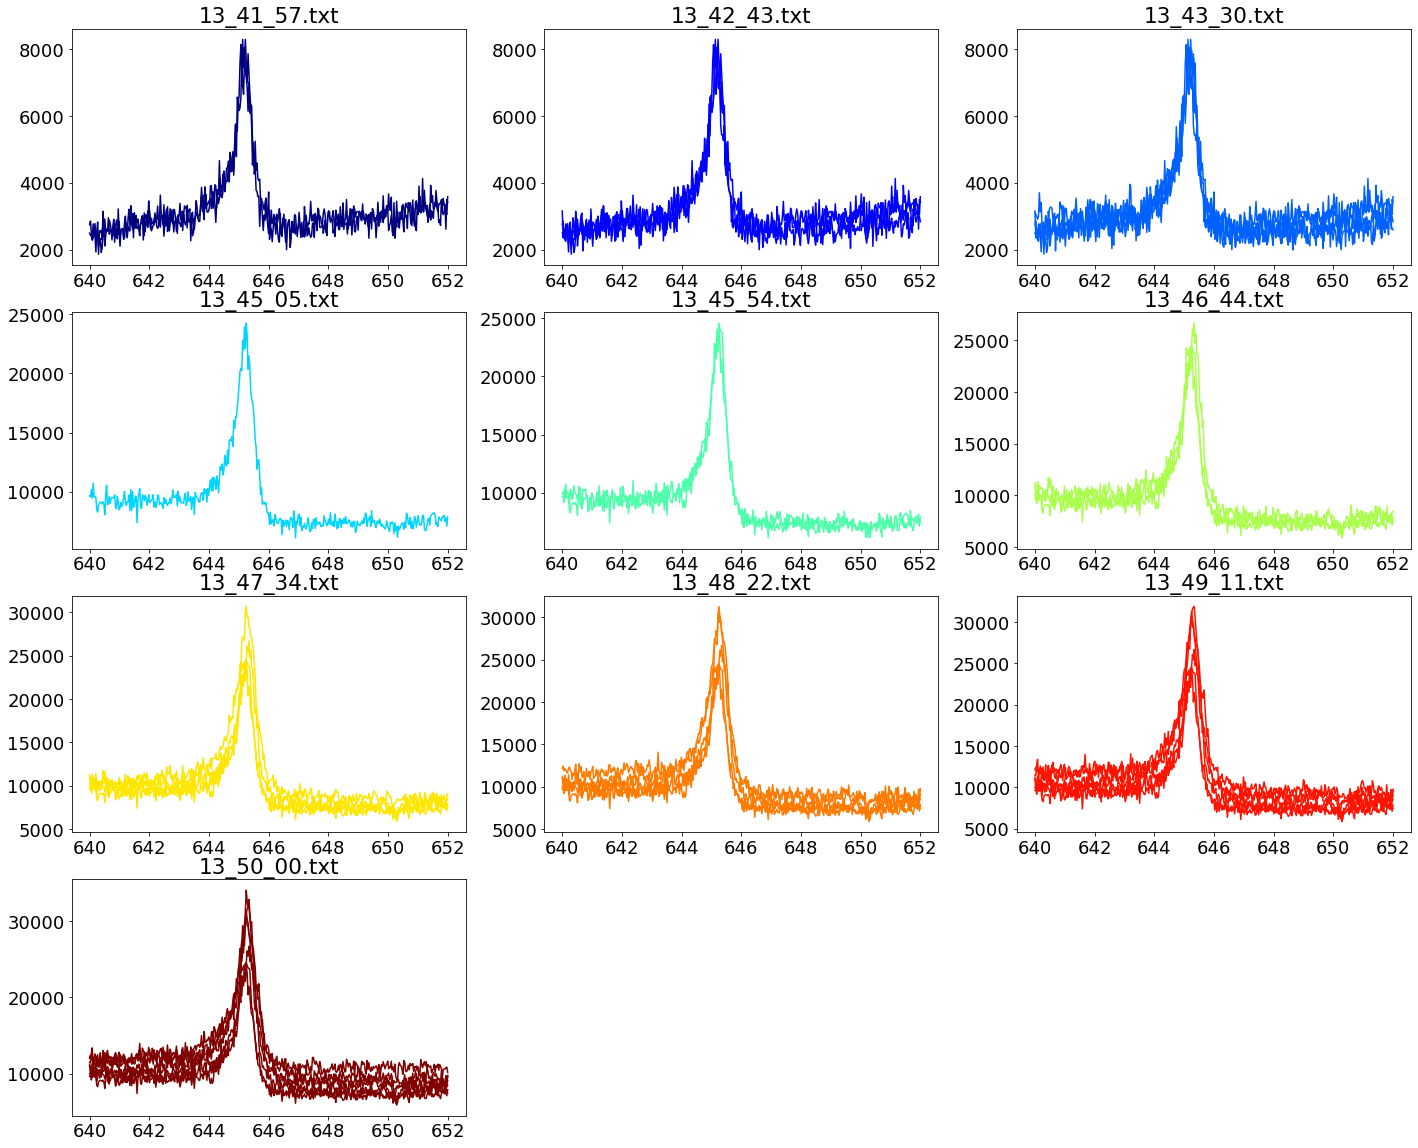

In [179]:
color = plt.cm.jet(np.linspace(0, 1, len(siv_files)))
plt.figure(figsize=[24, 20])

for i, file in enumerate(siv_files):
    siv_data = np.loadtxt(siv_path + file)

    # Convert from (401,) shape to (1, 401)
    if len(siv_data.shape) == 1: siv_data = siv_data.reshape(1, len(siv_data))

    # Extract SiV frequency axis
    siv_data_avg = np.loadtxt(siv_path.replace("scans", "avg") + file)
    siv_freqs = 1000 * (siv_data_avg[0] - 406)

    plt.subplot(4, 3, i+1)
    plt.gca().title.set_text(file)
    
    for siv_series in siv_data:
        plt.plot(siv_freqs, siv_series, c=color[i])

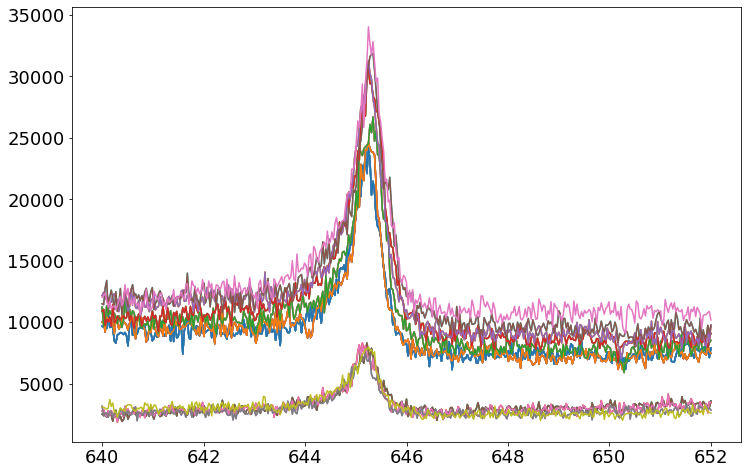

In [180]:
plt.figure(figsize=[12, 8])
for file in siv_files:
    siv_data = np.loadtxt(siv_path + file)
    if len(siv_data.shape) == 1: siv_data = siv_data.reshape(1, len(siv_data))
    
    # Extract SiV frequency axis
    siv_data_avg = np.loadtxt(siv_path.replace("scans", "avg") + file)
    siv_freqs = 1000 * (siv_data_avg[0] - 406)
    
    for siv_series in siv_data:
        plt.plot(siv_freqs, siv_series)

# Fit Cavity Spectrum

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 80
    # data points      = 121
    # variables        = 5
    chi-square         = 1.0741e+08
    reduced chi-square = 925939.398
    Akaike info crit   = 1667.26001
    Bayesian info crit = 1681.23896
[[Variables]]
    w_c:    721.859341 +/- 1.03675415 (0.14%) (init = 700)
    k_in:   37.7011050 +/- 9753600.40 (25870860.84%) (init = 100)
    k_tot:  164.092706 +/- 4.54734643 (2.77%) (init = 100)
    A:      43593.5376 +/- 7.9139e+09 (18153868.97%) (init = 40000)
    B:      852.152437 +/- 7.9139e+09 (928698317.17%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, B)        = -1.000
    C(k_in, B)     =  1.000
    C(k_in, A)     = -1.000
    C(k_tot, A)    =  0.131
    C(k_tot, B)    = -0.131
    C(k_in, k_tot) = -0.131


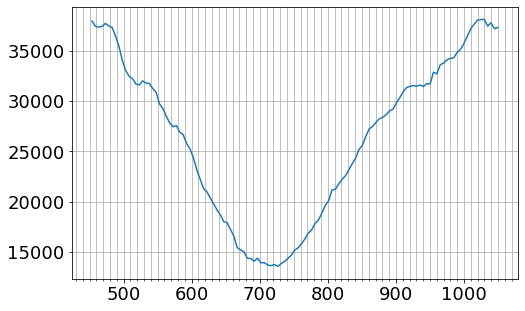

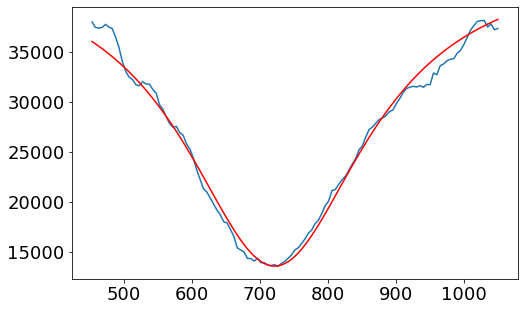

In [6]:
freq_lo = 450
freq_hi = 1050

cavity_freqs_filtered = cavity_freqs[np.logical_and(freq_lo < cavity_freqs, cavity_freqs < freq_hi)]
cavity_counts_filtered = cavity_counts[np.logical_and(freq_lo < cavity_freqs, cavity_freqs < freq_hi)]
plt.plot(cavity_freqs_filtered, cavity_counts_filtered)

plt.gca().xaxis.set_minor_locator(MultipleLocator(10))
plt.gca().yaxis.set_minor_locator(MultipleLocator(5000))
plt.grid(which='both')

##############################

params = Parameters()
params.add_many(
    Parameter('w_c', value=700, min=690, max=730),
    Parameter('k_in', value=100, min=0, max=1000),
    Parameter('k_tot', value=100, min=0, max=1000),
    Parameter('A', value=40000, min=0, max=70000),
    Parameter('B', value=0.1, min=0, max=1000),
)

results = fitter.fit_reflection(params, cavity_freqs_filtered, cavity_counts_filtered, fit_func=fitter.cavity_ref)
lmfit.report_fit(results)

# Compare actual data with fit. Have to add the y-data to the prediction since the function subtracted the y-data 
# in its definition (so that it can try to minimize that function value)
# Alternative: plt.plot(cavity_freqs_filtered, cavity_counts_filtered + results.residual, 'r')
plt.figure()
plt.plot(cavity_freqs_filtered, cavity_counts_filtered)
plt.plot(cavity_freqs_filtered, fitter.cavity_ref(results.params, cavity_freqs_filtered, cavity_counts_filtered) + cavity_counts_filtered, 'r')

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 137
    # data points      = 50
    # variables        = 5
    chi-square         = 3657429.03
    reduced chi-square = 81276.2006
    Akaike info crit   = 570.012400
    Bayesian info crit = 579.572515
[[Variables]]
    w_c:    715.953499 +/- 0.43675209 (0.06%) (init = 700)
    k_in:   124.675367 +/- 2221517.43 (1781841.49%) (init = 100)
    k_tot:  159.399874 +/- 9.07243447 (5.69%) (init = 100)
    A:      42641.4685 +/- 1.9682e+09 (4615718.40%) (init = 40000)
    B:      2.5201e-04 +/- 1.9605e+09 (777934518632151.75%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, B)       = -1.000
    C(k_in, A)    =  1.000
    C(k_in, B)    = -1.000
    C(w_c, k_tot) =  0.164


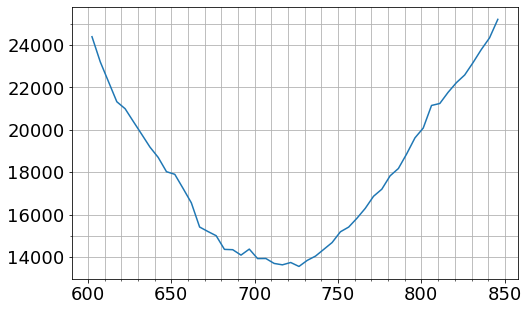

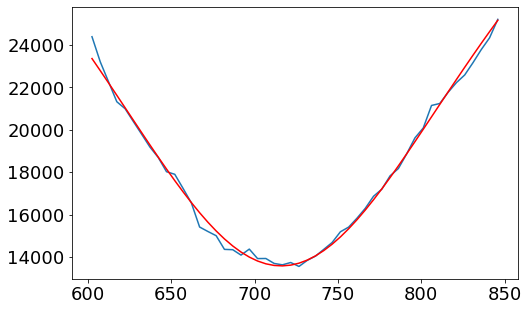

In [20]:
freq_lo = 600
freq_hi = 850

cavity_freqs_filtered = cavity_freqs[np.logical_and(freq_lo < cavity_freqs, cavity_freqs < freq_hi)]
cavity_counts_filtered = cavity_counts[np.logical_and(freq_lo < cavity_freqs, cavity_freqs < freq_hi)]
plt.plot(cavity_freqs_filtered, cavity_counts_filtered)

plt.gca().xaxis.set_minor_locator(MultipleLocator(10))
plt.gca().yaxis.set_minor_locator(MultipleLocator(5000))
plt.grid(which='both')

##############################

params = Parameters()
params.add_many(
    Parameter('w_c', value=700, min=690, max=730),
    Parameter('k_in', value=100, min=0, max=1000),
    Parameter('k_tot', value=100, min=0, max=1000),
    Parameter('A', value=40000, min=0, max=70000),
    Parameter('B', value=0.1, min=0, max=1000),
)

results = fitter.fit_reflection(params, cavity_freqs_filtered, cavity_counts_filtered, fit_func=fitter.cavity_ref)
lmfit.report_fit(results)

plt.figure()
plt.plot(cavity_freqs_filtered, cavity_counts_filtered)
plt.plot(cavity_freqs_filtered, cavity_counts_filtered + results.residual, 'r')

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 42
    # data points      = 50
    # variables        = 4
    chi-square         = 3657428.73
    reduced chi-square = 79509.3202
    Akaike info crit   = 568.012396
    Bayesian info crit = 575.660488
[[Variables]]
    w_c:    715.953167 +/- 0.43135834 (0.06%) (init = 700)
    k_in:   110 (fixed)
    k_tot:  159.382881 +/- 8.96808812 (5.63%) (init = 100)
    A:      33972.4186 +/- 417.131557 (1.23%) (init = 40000)
    B:      8664.89483 +/- 2037.56965 (23.52%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_tot, B)   =  0.998
    C(k_tot, A)   =  0.360
    C(A, B)       =  0.310
    C(w_c, A)     =  0.189
    C(w_c, k_tot) =  0.163
    C(w_c, B)     =  0.156


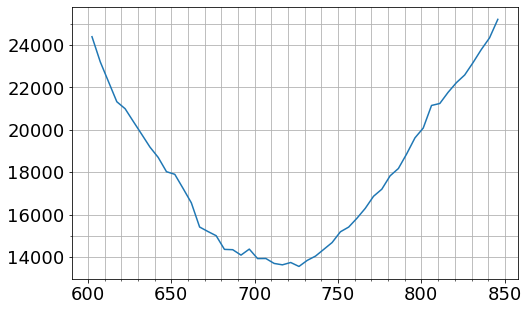

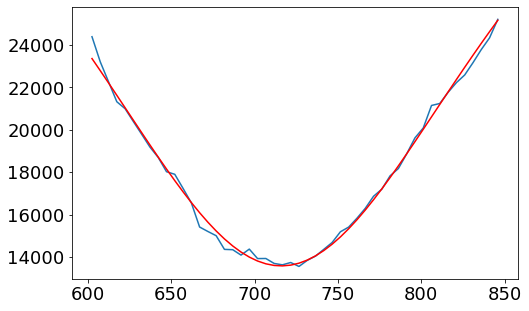

In [16]:
freq_lo = 600
freq_hi = 850

cavity_freqs_filtered = cavity_freqs[np.logical_and(freq_lo < cavity_freqs, cavity_freqs < freq_hi)]
cavity_counts_filtered = cavity_counts[np.logical_and(freq_lo < cavity_freqs, cavity_freqs < freq_hi)]
plt.plot(cavity_freqs_filtered, cavity_counts_filtered)

plt.gca().xaxis.set_minor_locator(MultipleLocator(10))
plt.gca().yaxis.set_minor_locator(MultipleLocator(5000))
plt.grid(which='both')

##############################

params = Parameters()
params.add_many(
    Parameter('w_c', value=700, min=690, max=730),
    Parameter('k_in', value=110, vary=False),
    Parameter('k_tot', value=100, min=0, max=1000),
    Parameter('A', value=40000, min=0, max=70000),
    Parameter('B', value=0.1, min=0, max=10000),
)

results = fitter.fit_reflection(params, cavity_freqs_filtered, cavity_counts_filtered, fit_func=fitter.cavity_ref)
lmfit.report_fit(results)

plt.figure()
plt.plot(cavity_freqs_filtered, cavity_counts_filtered)
plt.plot(cavity_freqs_filtered, cavity_counts_filtered + results.residual, 'r')

# Fit SiV Spectrum
## Fitting SiV index 0

2


<ErrorbarContainer object of 3 artists>

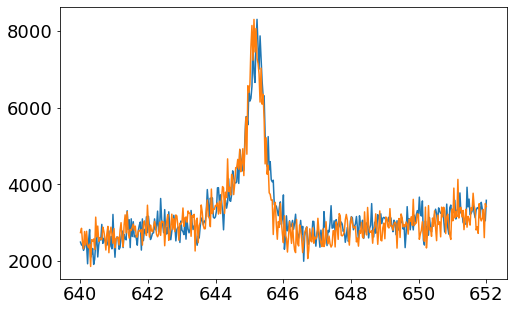

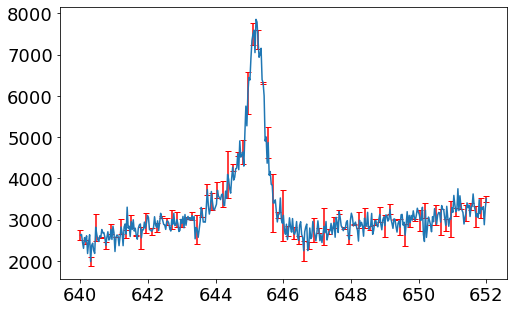

In [18]:
siv_index = 0

siv_data = np.loadtxt(siv_path + siv_files[siv_index])
if len(siv_data.shape) == 1: siv_data = siv_data.reshape(1, len(siv_data))

# Extract SiV frequency axis
siv_data_avg = np.loadtxt(siv_path.replace("scans", "avg") + siv_files[siv_index])
siv_freqs = 1000 * (siv_data_avg[0] - 406)

print(len(siv_data))

for i in range(len(siv_data)):
    plt.plot(siv_freqs, siv_data[i])

plt.figure()
siv_mean = np.sum(siv_data, axis=0)/len(siv_data)
siV_error = np.std(siv_data, axis=0)
plt.errorbar(siv_freqs, siv_mean, yerr=siV_error, errorevery=5, ecolor="r", capsize=3)

### Free fitting

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7955
    # data points      = 401
    # variables        = 8
    chi-square         = 17136869.1
    reduced chi-square = 43605.2649
    Akaike info crit   = 4291.77533
    Bayesian info crit = 4323.72702
[[Variables]]
    w_up:      645.208695 +/- 0.02024587 (0.00%) (init = 645)
    g_up:      2.90037314 +/- 0.09440599 (3.25%) (init = 5.6)
    gamma_up:  3.6715e-08 +/- 0.29360588 (799699182.79%) (init = 0.1)
    w_c:       640.678360 +/- 0.69873672 (0.11%) (init = 715)
    k_in:      19.8267774 +/- 961392.315 (4848959.04%) (init = 100)
    k_tot:     26.3606868 +/- 4.21764396 (16.00%) (init = 150)
    A:         6687.53624 +/- 6.5975e+08 (9865419.92%) (init = 6000)
    B:         961.282746 +/- 6.6004e+08 (68661944.95%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, A)         =  1.000
    C(k_in, B)         = -1.000
    C(A, B)            = -1.000
    C(w_up, gamma_up)  = -0.

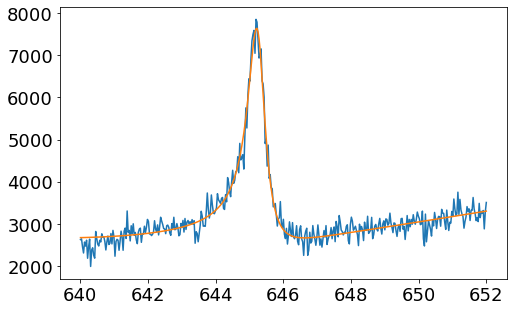

In [22]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=645, min=644, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, min=0, max=5),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=100, min=0, max=200),
    Parameter('k_tot', value=150, min=0, max=300),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0.1, min=0, max=1000),
)

results = fitter.fit_reflection(params, siv_freqs, siv_mean, fit_func=fitter.single_siv_ref)
lmfit.report_fit(results)

plt.plot(siv_freqs, siv_mean)
plt.plot(siv_freqs, siv_mean + results.residual)

### Fix total kappa

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 957
    # data points      = 401
    # variables        = 7
    chi-square         = 19524214.5
    reduced chi-square = 49553.8438
    Akaike info crit   = 4342.07504
    Bayesian info crit = 4370.03277
[[Variables]]
    w_up:      645.255932 +/- 0.00773574 (0.00%) (init = 645)
    g_up:      3.40408466 +/- 0.13788681 (4.05%) (init = 5.6)
    gamma_up:  0.23850928 +/- 0.00933299 (3.91%) (init = 0.1)
    w_c:       642.858175 +/- 0.48310654 (0.08%) (init = 715)
    k_in:      86.7019427 +/- 1.54073940 (1.78%) (init = 100)
    k_tot:     159.38 (fixed)
    A:         236410.028 +/- 32329.4735 (13.68%) (init = 6000)
    B:         1000.00000 +/- 923.616242 (92.36%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, B)        =  0.979
    C(g_up, k_in)     =  0.951
    C(w_c, A)         =  0.904
    C(w_c, B)         =  0.894
    C(g_up, B)        =  0.893
    C(w_c, k_in)      =  0.8

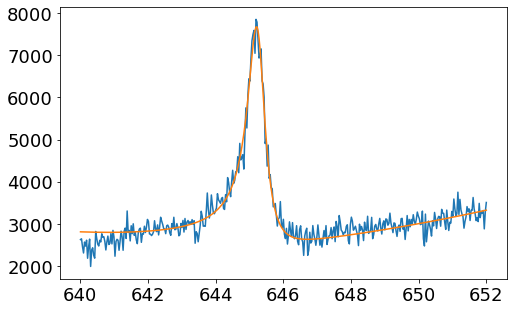

In [23]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=645, min=644, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, min=0, max=5),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=100, min=0, max=200),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0.1, min=0, max=1000),
)

results = fitter.fit_reflection(params, siv_freqs, siv_mean, fit_func=fitter.single_siv_ref)
lmfit.report_fit(results)

plt.plot(siv_freqs, siv_mean)
plt.plot(siv_freqs, siv_mean + results.residual)

### Fix total kappa, gamma

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 233
    # data points      = 401
    # variables        = 6
    chi-square         = 28928245.2
    reduced chi-square = 73236.0638
    Akaike info crit   = 4497.73340
    Bayesian info crit = 4521.69717
[[Variables]]
    w_up:      645.235478 +/- 0.01105568 (0.00%) (init = 645)
    g_up:      5.20730492 +/- 0.12756715 (2.45%) (init = 5.6)
    gamma_up:  0.1 (fixed)
    w_c:       638.586698 +/- 8.62291450 (1.35%) (init = 715)
    k_in:      104.422913 +/- 20.2156861 (19.36%) (init = 100)
    k_tot:     159.38 (fixed)
    A:         29553.3717 +/- 42483.5295 (143.75%) (init = 6000)
    B:         4.5956e-04 +/- 164554.850 (35806764896.19%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, B)    =  1.000
    C(A, B)       =  0.999
    C(k_in, A)    =  0.998
    C(w_c, A)     =  0.998
    C(w_c, B)     =  0.998
    C(w_c, k_in)  =  0.996
    C(w_up, A)    =  0.709
    C(w_up, B)    

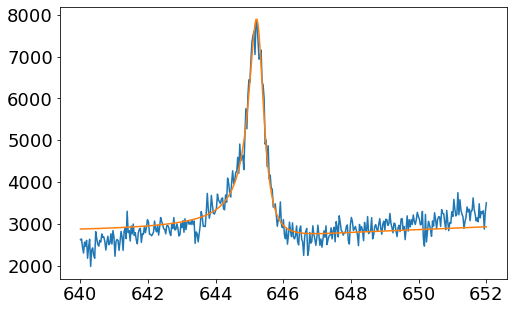

In [19]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=645, min=644, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, vary=False),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=100, min=0, max=200),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0.1, min=0, max=1000),
)

results = fitter.fit_reflection(params, siv_freqs, siv_mean, fit_func=fitter.single_siv_ref)
lmfit.report_fit(results)

plt.plot(siv_freqs, siv_mean)
plt.plot(siv_freqs, siv_mean + results.residual)

## Fitting SiV index 1
### Fix total kappa

3
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 584
    # data points      = 401
    # variables        = 7
    chi-square         = 11373759.6
    reduced chi-square = 28867.4102
    Akaike info crit   = 4125.39608
    Bayesian info crit = 4153.35381
[[Variables]]
    w_up:      645.242733 +/- 0.00612325 (0.00%) (init = 645)
    g_up:      3.56009542 +/- 0.12518310 (3.52%) (init = 5.6)
    gamma_up:  0.23534965 +/- 0.00792466 (3.37%) (init = 0.1)
    w_c:       642.638054 +/- 0.48396800 (0.08%) (init = 715)
    k_in:      87.3077755 +/- 1.52225899 (1.74%) (init = 100)
    k_tot:     159.38 (fixed)
    A:         193007.872 +/- 25175.5896 (13.04%) (init = 6000)
    B:         999.999999 +/- 1774.65764 (177.47%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, B)        =  0.980
    C(g_up, k_in)     =  0.951
    C(w_c, A)         =  0.918
    C(w_c, B)         =  0.917
    C(g_up, B)        =  0.889
    C(w_c, k_in)      =  

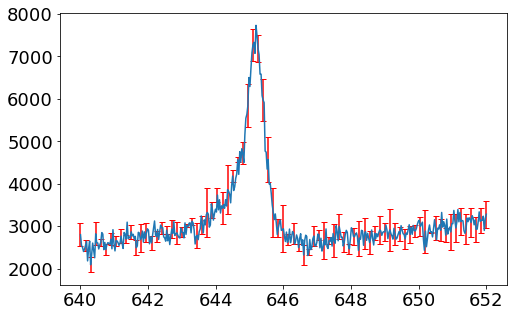

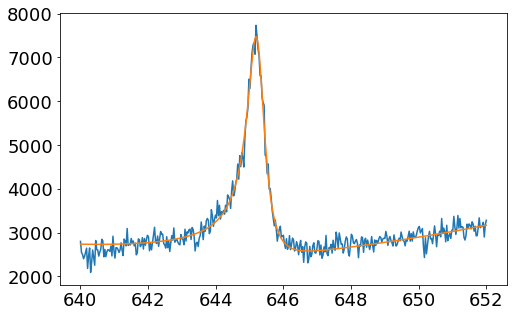

In [39]:
siv_index = 1

siv_data = np.loadtxt(siv_path + siv_files[siv_index])
if len(siv_data.shape) == 1: siv_data = siv_data.reshape(1, len(siv_data))

# Extract SiV frequency axis
siv_data_avg = np.loadtxt(siv_path.replace("scans", "avg") + siv_files[siv_index])
siv_freqs = 1000 * (siv_data_avg[0] - 406)

print(len(siv_data))

siv_mean = np.sum(siv_data, axis=0)/len(siv_data)
siV_error = np.std(siv_data, axis=0)     
plt.errorbar(siv_freqs, siv_mean, yerr=siV_error, errorevery=5, ecolor="r", capsize=3)

plt.figure()
params = Parameters()
params.add_many(
    Parameter('w_up', value=645, min=644, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, min=0, max=5),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=100, min=0, max=200),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0.1, min=0, max=1000),
)

results = fitter.fit_reflection(params, siv_freqs, siv_mean, fit_func=fitter.single_siv_ref)
lmfit.report_fit(results)

plt.plot(siv_freqs, siv_mean)
plt.plot(siv_freqs, siv_mean + results.residual)

### Fix total kappa, gammma

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 202
    # data points      = 401
    # variables        = 6
    chi-square         = 17707396.2
    reduced chi-square = 44828.8513
    Akaike info crit   = 4300.90815
    Bayesian info crit = 4324.87192
[[Variables]]
    w_up:      645.226335 +/- 0.01001556 (0.00%) (init = 645)
    g_up:      5.33591583 +/- 0.10160710 (1.90%) (init = 5.6)
    gamma_up:  0.1 (fixed)
    w_c:       638.034799 +/- 7.91014647 (1.24%) (init = 715)
    k_in:      105.041356 +/- 17.8365979 (16.98%) (init = 100)
    k_tot:     159.38 (fixed)
    A:         27333.0968 +/- 33663.9128 (123.16%) (init = 6000)
    B:         9.2186e-04 +/- 12573.2190 (1363902030.58%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, B)    =  1.000
    C(A, B)       =  0.999
    C(k_in, A)    =  0.998
    C(w_c, A)     =  0.998
    C(w_c, B)     =  0.998
    C(w_c, k_in)  =  0.997
    C(w_up, A)    =  0.770
    C(w_up, B)    =

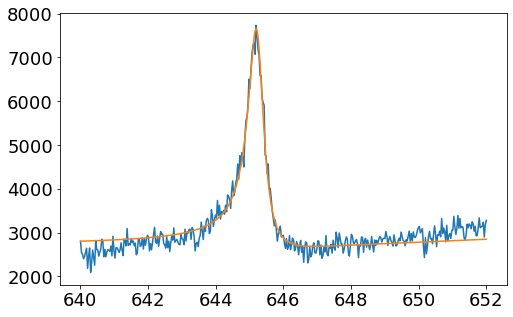

In [40]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=645, min=644, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, vary=False),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=100, min=0, max=200),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0.1, min=0, max=1000),
)

results = fitter.fit_reflection(params, siv_freqs, siv_mean, fit_func=fitter.single_siv_ref)
lmfit.report_fit(results)

plt.plot(siv_freqs, siv_mean)
plt.plot(siv_freqs, siv_mean + results.residual)

## Fitting SiV index 2
### Fix total kappa

4
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 375
    # data points      = 401
    # variables        = 7
    chi-square         = 8324555.83
    reduced chi-square = 21128.3143
    Akaike info crit   = 4000.24428
    Bayesian info crit = 4028.20201
[[Variables]]
    w_up:      645.258909 +/- 0.00509262 (0.00%) (init = 645)
    g_up:      4.01245455 +/- 0.13940950 (3.47%) (init = 5.6)
    gamma_up:  0.21309162 +/- 0.00849269 (3.99%) (init = 0.1)
    w_c:       641.335412 +/- 0.94084414 (0.15%) (init = 715)
    k_in:      89.5859055 +/- 2.38633730 (2.66%) (init = 100)
    k_tot:     159.38 (fixed)
    A:         112783.658 +/- 21842.5948 (19.37%) (init = 6000)
    B:         999.999979 +/- 367.696010 (36.77%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, B)        =  0.981
    C(w_c, A)         =  0.957
    C(w_c, B)         =  0.956
    C(g_up, k_in)     =  0.921
    C(w_c, k_in)      =  0.889
    C(A, B)           =  0

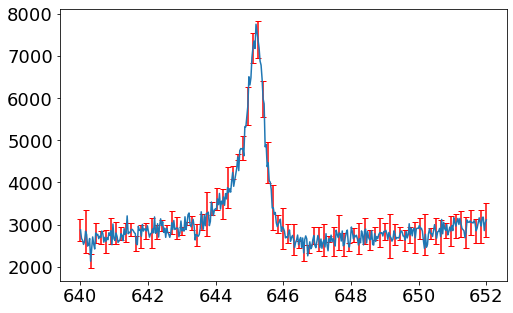

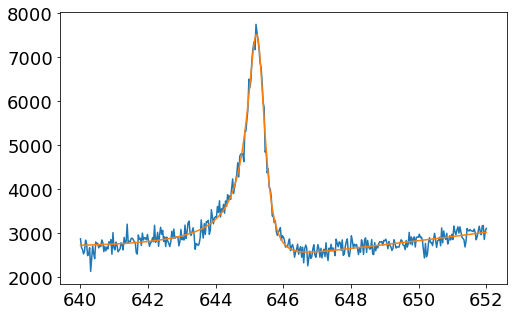

In [41]:
siv_index = 2

siv_data = np.loadtxt(siv_path + siv_files[siv_index])
if len(siv_data.shape) == 1: siv_data = siv_data.reshape(1, len(siv_data))

# Extract SiV frequency axis
siv_data_avg = np.loadtxt(siv_path.replace("scans", "avg") + siv_files[siv_index])
siv_freqs = 1000 * (siv_data_avg[0] - 406)

print(len(siv_data))

siv_mean = np.sum(siv_data, axis=0)/len(siv_data)
siV_error = np.std(siv_data, axis=0)     
plt.errorbar(siv_freqs, siv_mean, yerr=siV_error, errorevery=5, ecolor="r", capsize=3)

plt.figure()
params = Parameters()
params.add_many(
    Parameter('w_up', value=645, min=644, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, min=0, max=5),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=100, min=0, max=200),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0.1, min=0, max=1000),
)

results = fitter.fit_reflection(params, siv_freqs, siv_mean, fit_func=fitter.single_siv_ref)
lmfit.report_fit(results)

plt.plot(siv_freqs, siv_mean)
plt.plot(siv_freqs, siv_mean + results.residual)

### Fix total kappa, gammma

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 190
    # data points      = 401
    # variables        = 6
    chi-square         = 10755509.3
    reduced chi-square = 27229.1374
    Akaike info crit   = 4100.98386
    Bayesian info crit = 4124.94763
[[Variables]]
    w_up:      645.246384 +/- 0.01020132 (0.00%) (init = 645)
    g_up:      5.50896856 +/- 0.07533472 (1.37%) (init = 5.6)
    gamma_up:  0.1 (fixed)
    w_c:       636.234331 +/- 8.29589958 (1.30%) (init = 715)
    k_in:      105.698318 +/- 15.9750103 (15.11%) (init = 100)
    k_tot:     159.38 (fixed)
    A:         25594.9888 +/- 26762.4610 (104.56%) (init = 6000)
    B:         3.1283e-04 +/- 6101.02613 (1950295595.19%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, B)    = -1.000
    C(A, B)       = -1.000
    C(w_c, A)     =  0.999
    C(w_c, B)     = -0.999
    C(k_in, A)    =  0.999
    C(w_c, k_in)  =  0.998
    C(w_up, A)    =  0.871
    C(w_up, B)    =

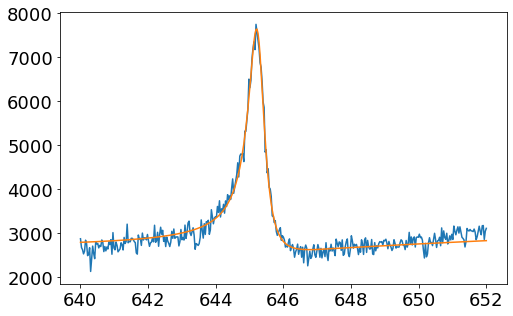

In [42]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=645, min=644, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, vary=False),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=100, min=0, max=200),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0.1, min=0, max=1000),
)

results = fitter.fit_reflection(params, siv_freqs, siv_mean, fit_func=fitter.single_siv_ref)
lmfit.report_fit(results)

plt.plot(siv_freqs, siv_mean)
plt.plot(siv_freqs, siv_mean + results.residual)

## Fitting SiV index 6
### Fix total kappa

4
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 188
    # data points      = 401
    # variables        = 7
    chi-square         = 1.3212e+08
    reduced chi-square = 335332.486
    Akaike info crit   = 5108.81219
    Bayesian info crit = 5136.76992
[[Variables]]
    w_up:      645.285446 +/- 0.05236240 (0.01%) (init = 645)
    g_up:      7.70378478 +/- 0.74053532 (9.61%) (init = 5.6)
    gamma_up:  1.3037e-09 +/- 0.05269449 (4041853735.31%) (init = 0.1)
    w_c:       608.066799 +/- 17.4659016 (2.87%) (init = 715)
    k_in:      121.654674 +/- 2608276.45 (2144000.19%) (init = 100)
    k_tot:     159.38 (fixed)
    A:         24139.3842 +/- 1.1514e+09 (4769859.25%) (init = 6000)
    B:         999.078617 +/- 1.1514e+09 (115249203.14%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, B)        = -1.000
    C(A, B)           = -1.000
    C(k_in, A)        =  1.000
    C(gamma_up, w_c)  =  0.998
    C(w_up, gamma_up) =  0.996

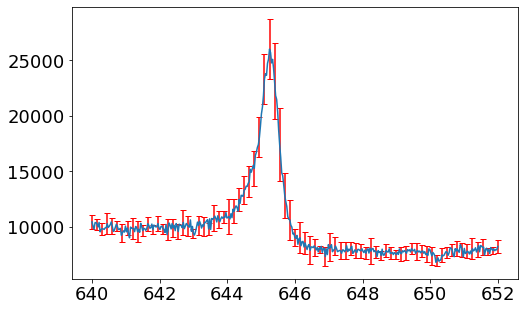

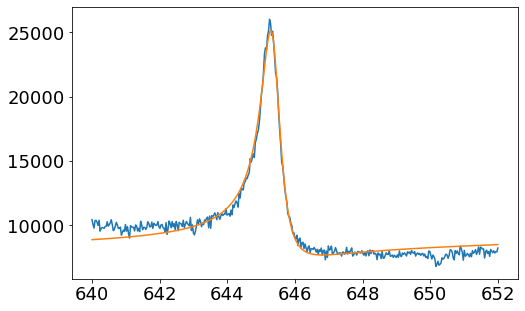

In [20]:
siv_index = 6

siv_data = np.loadtxt(siv_path + siv_files[siv_index])
if len(siv_data.shape) == 1: siv_data = siv_data.reshape(1, len(siv_data))

# Extract SiV frequency axis
siv_data_avg = np.loadtxt(siv_path.replace("scans", "avg") + siv_files[siv_index])
siv_freqs = 1000 * (siv_data_avg[0] - 406)

print(len(siv_data))

siv_mean = np.sum(siv_data, axis=0)/len(siv_data)
siV_error = np.std(siv_data, axis=0)
plt.errorbar(siv_freqs, siv_mean, yerr=siV_error, errorevery=5, ecolor="r", capsize=3)

plt.figure()
params = Parameters()
params.add_many(
    Parameter('w_up', value=645, min=644, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, min=0, max=5),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=100, min=0, max=200),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0.1, min=0, max=1000),
)

results = fitter.fit_reflection(params, siv_freqs, siv_mean, fit_func=fitter.single_siv_ref)
lmfit.report_fit(results)

plt.plot(siv_freqs, siv_mean)
plt.plot(siv_freqs, siv_mean + results.residual)

### Fix total kappa, gamma

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 240
    # data points      = 401
    # variables        = 6
    chi-square         = 1.5848e+08
    reduced chi-square = 401214.356
    Akaike info crit   = 5179.75736
    Bayesian info crit = 5203.72113
[[Variables]]
    w_up:      645.340066 +/- 0.04066475 (0.01%) (init = 645)
    g_up:      6.54537068 +/- 0.09904267 (1.51%) (init = 5.6)
    gamma_up:  0.1 (fixed)
    w_c:       628.880848 +/- 24.8343325 (3.95%) (init = 715)
    k_in:      107.486424 +/- 42.1396905 (39.20%) (init = 100)
    k_tot:     159.38 (fixed)
    A:         58335.7899 +/- 109978.734 (188.53%) (init = 6000)
    B:         999.998094 +/- 33876.5379 (3387.66%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, B)    = -1.000
    C(A, B)       = -1.000
    C(k_in, A)    =  1.000
    C(w_c, A)     =  1.000
    C(w_c, B)     = -1.000
    C(w_c, k_in)  =  1.000
    C(w_up, A)    =  0.988
    C(w_up, B)    = -0.98

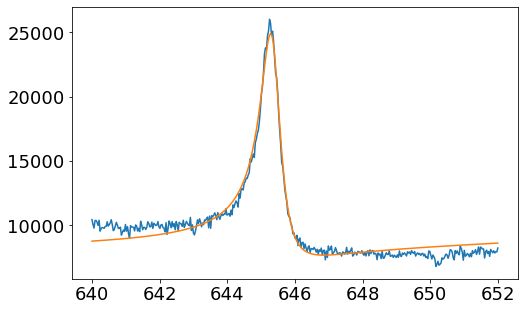

In [23]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=645, min=644, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, vary=False),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=100, min=0, max=200),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0.1, min=0, max=1000),
)

results = fitter.fit_reflection(params, siv_freqs, siv_mean, fit_func=fitter.single_siv_ref)
lmfit.report_fit(results)

plt.plot(siv_freqs, siv_mean)
plt.plot(siv_freqs, siv_mean + results.residual)

## Fitting SiV index 7
### Fix total kappa

5
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 280
    # data points      = 401
    # variables        = 7
    chi-square         = 1.4724e+08
    reduced chi-square = 373706.190
    Akaike info crit   = 5152.25948
    Bayesian info crit = 5180.21721
[[Variables]]
    w_up:      645.282746 +/- 0.05505917 (0.01%) (init = 645)
    g_up:      7.73570492 +/- 0.77259127 (9.99%) (init = 5.6)
    gamma_up:  8.6635e-10 +/- 0.21938637 (25323095622.65%) (init = 0.1)
    w_c:       607.787971 +/- 18.1741326 (2.99%) (init = 715)
    k_in:      121.718891 +/- 2022.70827 (1661.79%) (init = 100)
    k_tot:     159.38 (fixed)
    A:         24932.9049 +/- 927808.442 (3721.22%) (init = 6000)
    B:         1000.00000 +/- 889031.602 (88903.16%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, B)        = -1.000
    C(A, B)           = -1.000
    C(k_in, A)        =  1.000
    C(gamma_up, w_c)  = -0.998
    C(g_up, gamma_up) =  0.996
    C(w_

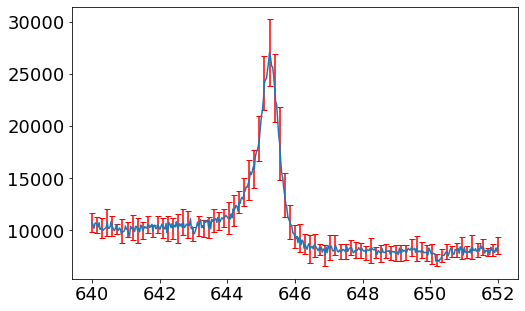

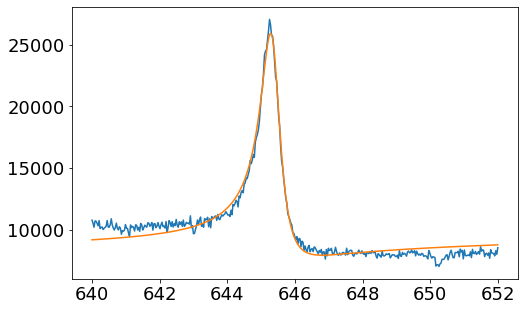

In [24]:
siv_index = 7

siv_data = np.loadtxt(siv_path + siv_files[siv_index])
if len(siv_data.shape) == 1: siv_data = siv_data.reshape(1, len(siv_data))

# Extract SiV frequency axis
siv_data_avg = np.loadtxt(siv_path.replace("scans", "avg") + siv_files[siv_index])
siv_freqs = 1000 * (siv_data_avg[0] - 406)

print(len(siv_data))

siv_mean = np.sum(siv_data, axis=0)/len(siv_data)
siV_error = np.std(siv_data, axis=0)     
plt.errorbar(siv_freqs, siv_mean, yerr=siV_error, errorevery=5, ecolor="r", capsize=3)

plt.figure()
params = Parameters()
params.add_many(
    Parameter('w_up', value=645, min=644, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, min=0, max=5),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=100, min=0, max=200),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0.1, min=0, max=1000),
)

results = fitter.fit_reflection(params, siv_freqs, siv_mean, fit_func=fitter.single_siv_ref)
lmfit.report_fit(results)

plt.plot(siv_freqs, siv_mean)
plt.plot(siv_freqs, siv_mean + results.residual)

### Fix total kappa, gamma

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 167
    # data points      = 401
    # variables        = 6
    chi-square         = 1.7665e+08
    reduced chi-square = 447223.302
    Akaike info crit   = 5223.29079
    Bayesian info crit = 5247.25456
[[Variables]]
    w_up:      645.337953 +/- 0.04280607 (0.01%) (init = 645)
    g_up:      6.58289250 +/- 0.10352004 (1.57%) (init = 5.6)
    gamma_up:  0.1 (fixed)
    w_c:       628.687571 +/- 25.8426323 (4.11%) (init = 715)
    k_in:      107.649049 +/- 43.6438384 (40.54%) (init = 100)
    k_tot:     159.38 (fixed)
    A:         59768.9864 +/- 116247.530 (194.49%) (init = 6000)
    B:         999.998285 +/- 36180.1415 (3618.02%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, B)    = -1.000
    C(A, B)       = -1.000
    C(k_in, A)    =  1.000
    C(w_c, A)     =  1.000
    C(w_c, B)     = -1.000
    C(w_c, k_in)  =  1.000
    C(w_up, A)    =  0.989
    C(w_up, B)    = -0.98

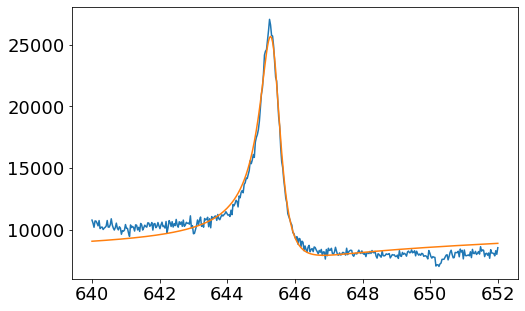

In [36]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=645, min=644, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, vary=False),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=100, min=0, max=200),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0.1, min=0, max=1000),
)

results = fitter.fit_reflection(params, siv_freqs, siv_mean, fit_func=fitter.single_siv_ref)
lmfit.report_fit(results)

plt.plot(siv_freqs, siv_mean)
plt.plot(siv_freqs, siv_mean + results.residual)

## Fitting SiV index 8
### Fix total kappa

6
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 165
    # data points      = 401
    # variables        = 7
    chi-square         = 1.5102e+08
    reduced chi-square = 383310.485
    Akaike info crit   = 5162.43502
    Bayesian info crit = 5190.39275
[[Variables]]
    w_up:      645.290931 +/- 0.05530993 (0.01%) (init = 645)
    g_up:      7.77139755 +/- 0.77674342 (9.99%) (init = 5.6)
    gamma_up:  7.9257e-11 +/- 0.00322435 (4068218779.82%) (init = 0.1)
    w_c:       608.812010 +/- 18.1609117 (2.98%) (init = 715)
    k_in:      122.149435 +/- 2610463.34 (2137106.35%) (init = 100)
    k_tot:     159.38 (fixed)
    A:         25558.2219 +/- 1.2458e+09 (4874504.29%) (init = 6000)
    B:         980.777656 +/- 1.2457e+09 (127015924.80%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, B)        = -1.000
    C(A, B)           = -1.000
    C(k_in, A)        =  1.000
    C(gamma_up, w_c)  = -0.998
    C(g_up, gamma_up) =  0.997

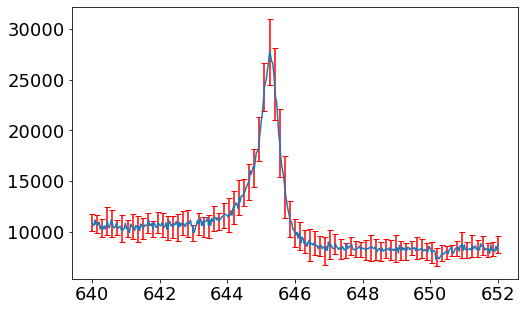

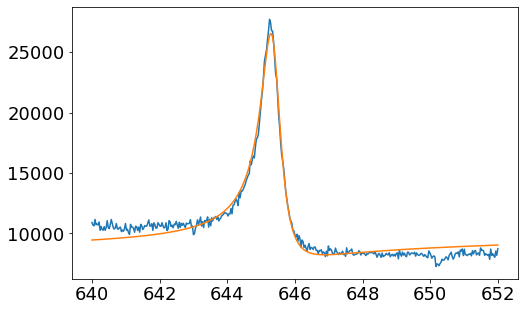

In [37]:
siv_index = 8

siv_data = np.loadtxt(siv_path + siv_files[siv_index])
if len(siv_data.shape) == 1: siv_data = siv_data.reshape(1, len(siv_data))

# Extract SiV frequency axis
siv_data_avg = np.loadtxt(siv_path.replace("scans", "avg") + siv_files[siv_index])
siv_freqs = 1000 * (siv_data_avg[0] - 406)

print(len(siv_data))

siv_mean = np.sum(siv_data, axis=0)/len(siv_data)
siV_error = np.std(siv_data, axis=0)     
plt.errorbar(siv_freqs, siv_mean, yerr=siV_error, errorevery=5, ecolor="r", capsize=3)

plt.figure()
params = Parameters()
params.add_many(
    Parameter('w_up', value=645, min=644, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, min=0, max=5),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=100, min=0, max=200),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0.1, min=0, max=1000),
)

results = fitter.fit_reflection(params, siv_freqs, siv_mean, fit_func=fitter.single_siv_ref)
lmfit.report_fit(results)

plt.plot(siv_freqs, siv_mean)
plt.plot(siv_freqs, siv_mean + results.residual)

### Fix total kappa, gamma 

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 144
    # data points      = 401
    # variables        = 6
    chi-square         = 1.8053e+08
    reduced chi-square = 457037.190
    Akaike info crit   = 5231.99520
    Bayesian info crit = 5255.95897
[[Variables]]
    w_up:      645.345333 +/- 0.04281445 (0.01%) (init = 645)
    g_up:      6.63105834 +/- 0.10114037 (1.53%) (init = 5.6)
    gamma_up:  0.1 (fixed)
    w_c:       629.106281 +/- 25.4503374 (4.05%) (init = 715)
    k_in:      107.961067 +/- 44.0750768 (40.82%) (init = 100)
    k_tot:     159.38 (fixed)
    A:         60770.3456 +/- 119846.186 (197.21%) (init = 6000)
    B:         999.998953 +/- 37849.9964 (3785.00%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, B)    = -1.000
    C(A, B)       = -1.000
    C(k_in, A)    =  1.000
    C(w_c, A)     =  1.000
    C(w_c, B)     = -1.000
    C(w_c, k_in)  =  1.000
    C(w_up, A)    =  0.989
    C(w_up, B)    = -0.98

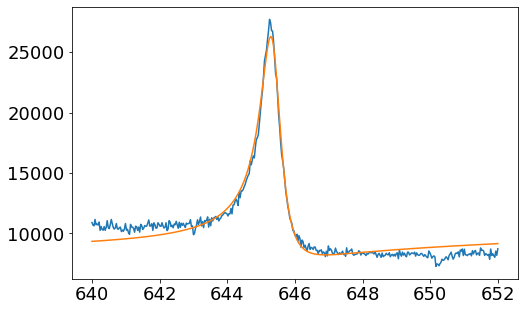

In [38]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=645, min=644, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, vary=False),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=100, min=0, max=200),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0.1, min=0, max=1000),
)

results = fitter.fit_reflection(params, siv_freqs, siv_mean, fit_func=fitter.single_siv_ref)
lmfit.report_fit(results)

plt.plot(siv_freqs, siv_mean)
plt.plot(siv_freqs, siv_mean + results.residual)

# Bulk SiV Fitting

In [8]:
def bulk_fit_siv(params, plot_fits=True):
    
    if plot_fits:
        plt.figure(figsize=[24, 20])   

    fit_params = defaultdict(list)
    fit_params_errors = defaultdict(list)
    reduced_chi = []

    for idx, file in enumerate(siv_files):
        # Get the SiV Data
        siv_data = np.loadtxt(siv_path + file)
        if len(siv_data.shape) == 1: siv_data = siv_data.reshape(1, len(siv_data))
        siv_mean = np.sum(siv_data, axis=0) / len(siv_data)

        # Extract SiV frequency axis
        siv_data_avg = np.loadtxt(siv_path.replace("scans", "avg") + file)
        siv_freqs = 1000 * (siv_data_avg[0] - 406)

        # Perform fit
        results = fitter.fit_reflection(params, siv_freqs, siv_mean, fit_func=fitter.single_siv_ref)

        # Store fit results
        for param, param_results in results.params.items():
            if not param_results.vary: continue
            fit_params[param].append(param_results.value)
            fit_params_errors[param].append(param_results.stderr)
        reduced_chi.append(results.redchi)
        
        if plot_fits:
            plt.subplot(4, 3, idx+1)
            plt.plot(siv_freqs, siv_mean)
            plt.plot(siv_freqs, siv_mean + results.residual)
        
    # Plot fit results
    plt.figure(figsize=[32, 10])   
    for idx, (param, param_fit) in enumerate(fit_params.items()):
        plt.subplot(2, 4, idx+1)
        x_axis = range(len(param_fit))
        errors = [err if err is not None else 0 for err in fit_params_errors[param]]
        plt.bar(x_axis, param_fit, yerr=errors)
        plt.title(param)
        plt.gca().relim() # Ignore error bar scales

    plt.subplot(2, 4, idx+2)
    plt.bar(range(len(reduced_chi)), reduced_chi)
    plt.title("Reduced $\chi^2$")
    
    return fit_params, fit_params_errors, reduced_chi

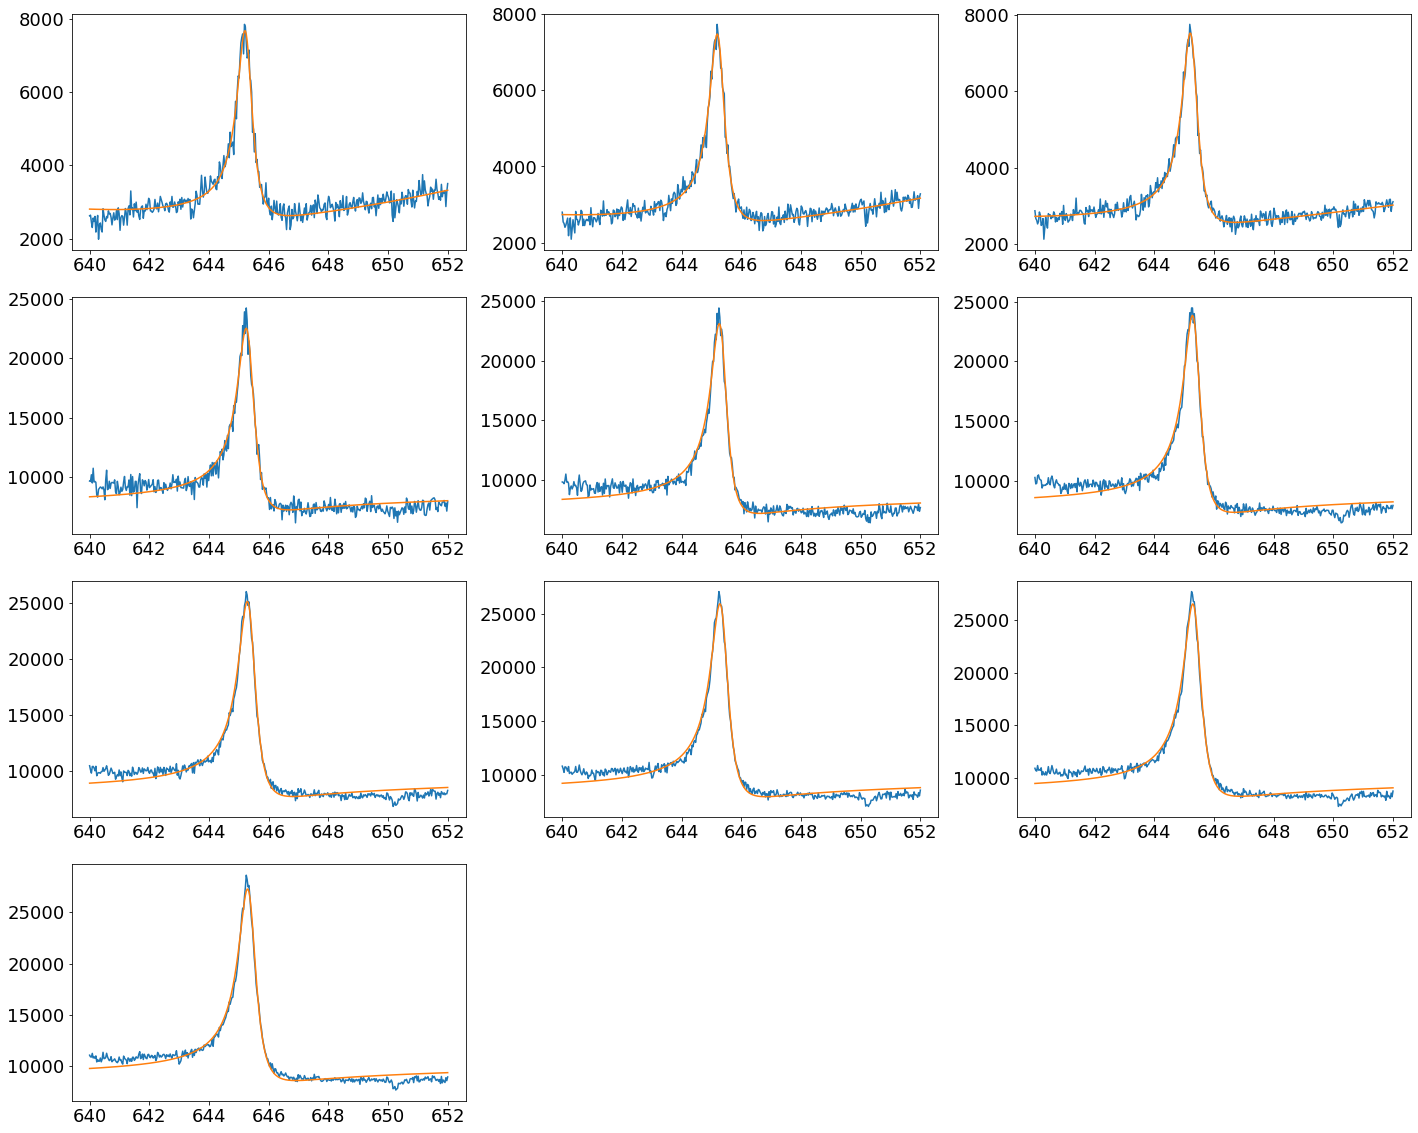

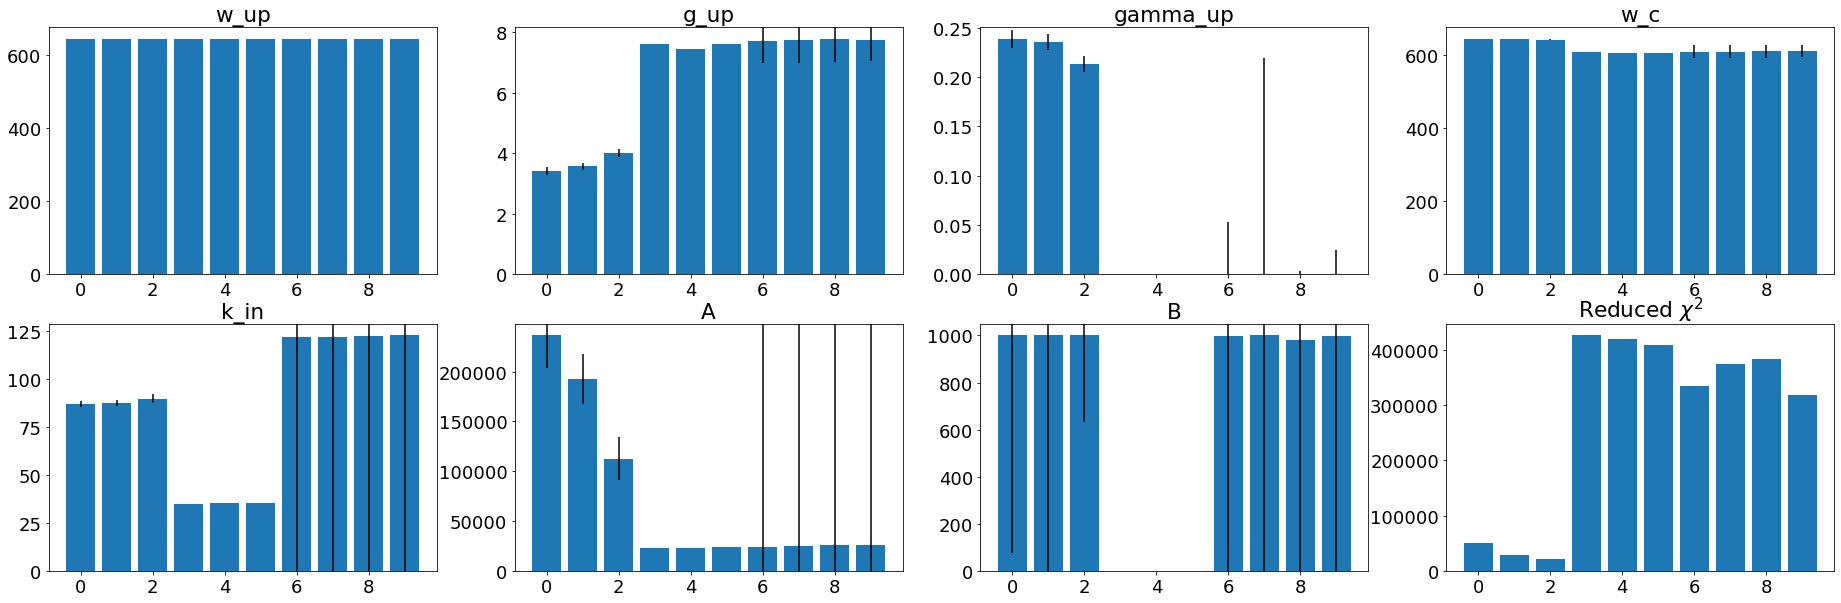

In [23]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=645, min=644, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, min=0, max=5),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=100, min=0, max=200),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0.1, min=0, max=1000),
)
fit_params, fit_params_errors, reduced_chi = bulk_fit_siv(params)

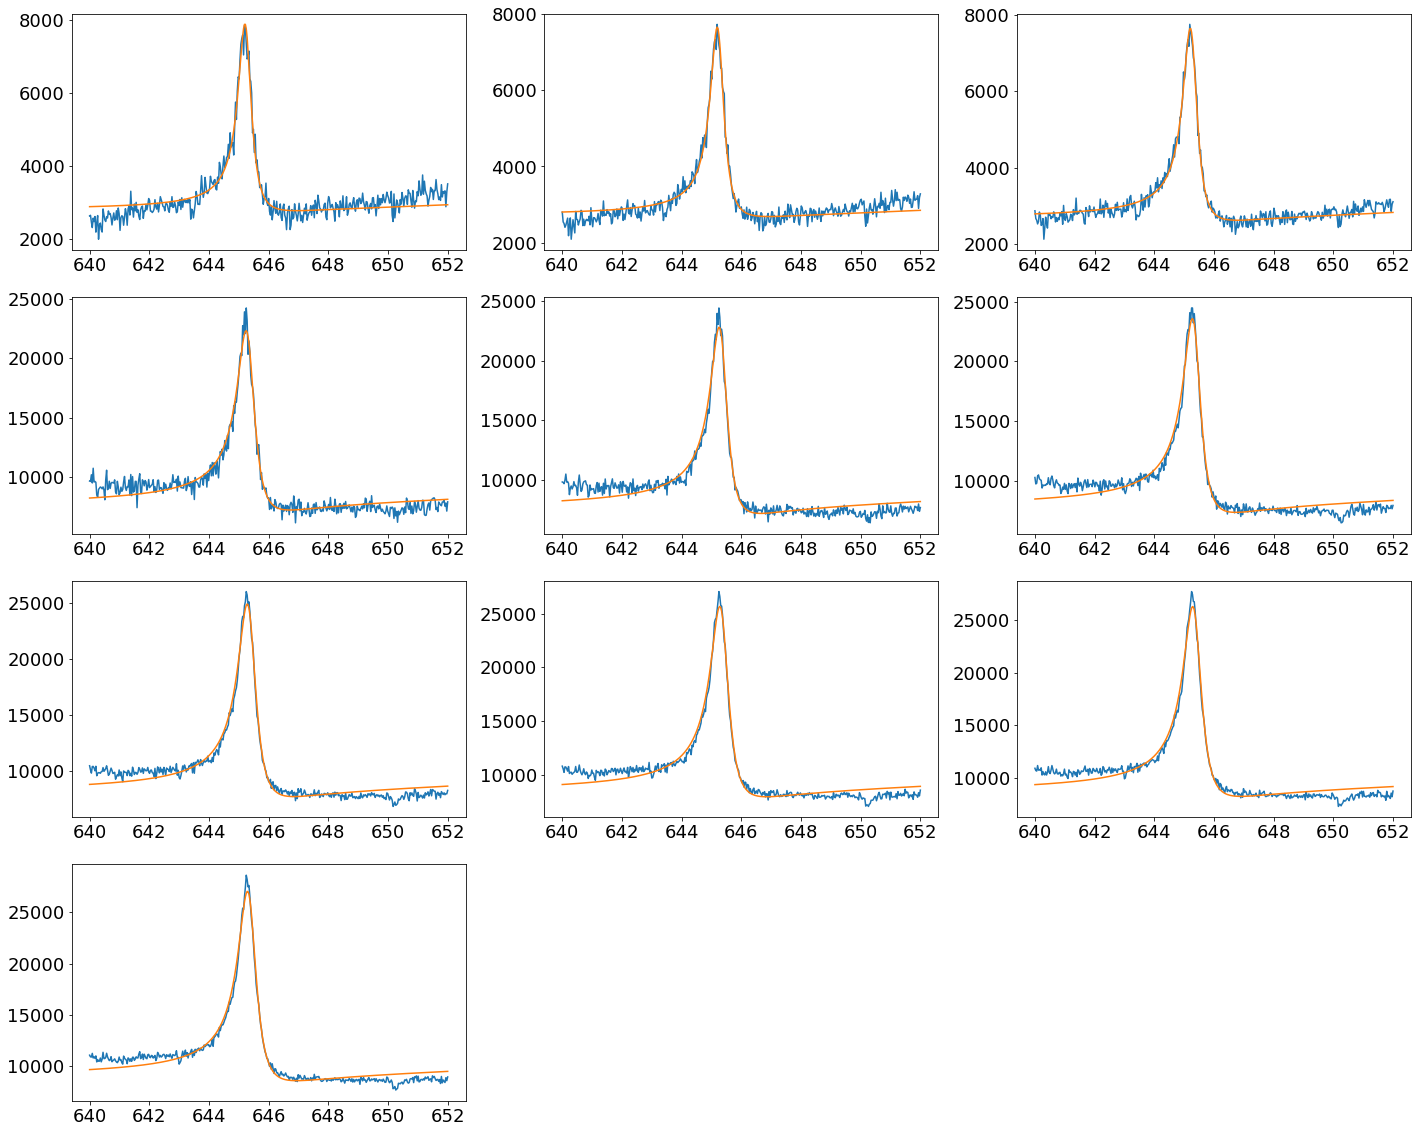

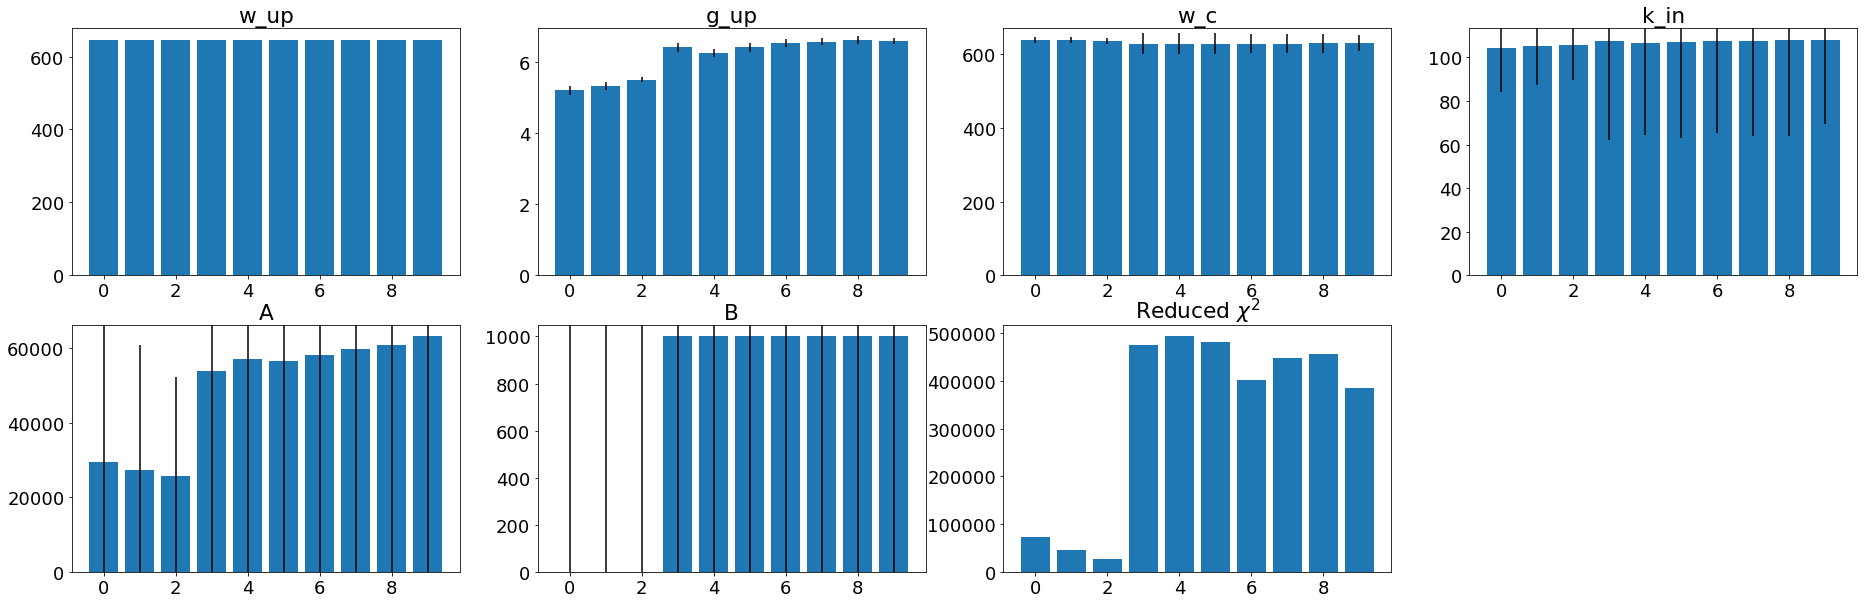

In [24]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=645, min=644, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, vary=False),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=100, min=0, max=200),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0.1, min=0, max=1000),
)
fit_params, fit_params_errors, reduced_chi = bulk_fit_siv(params)

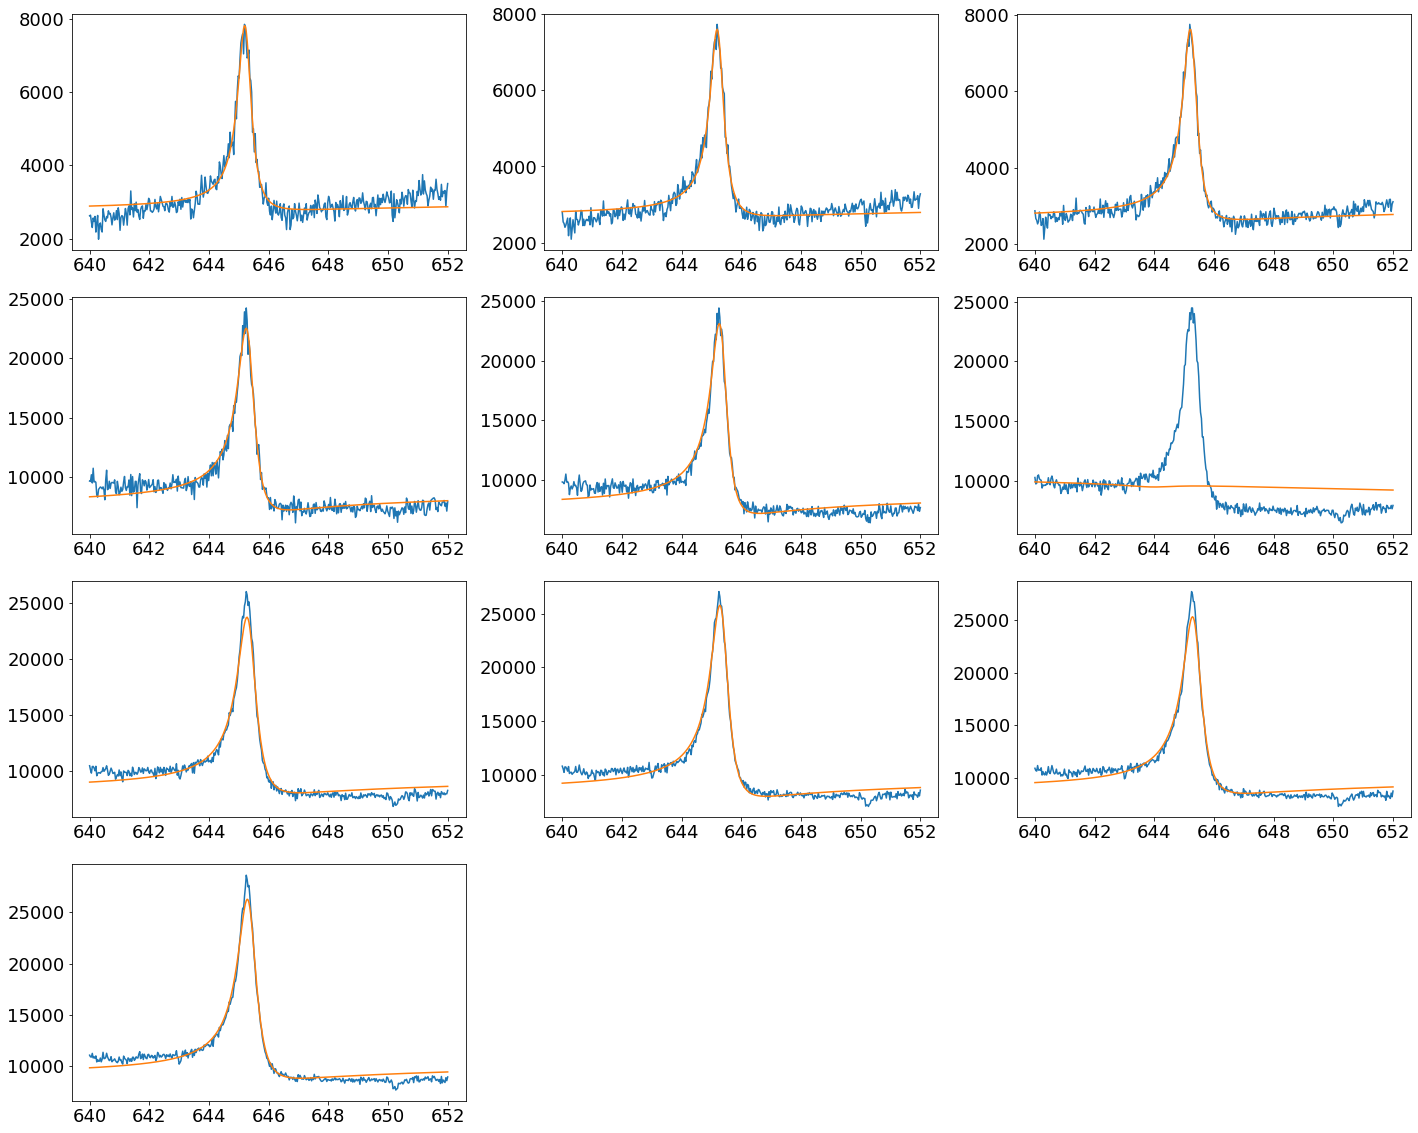

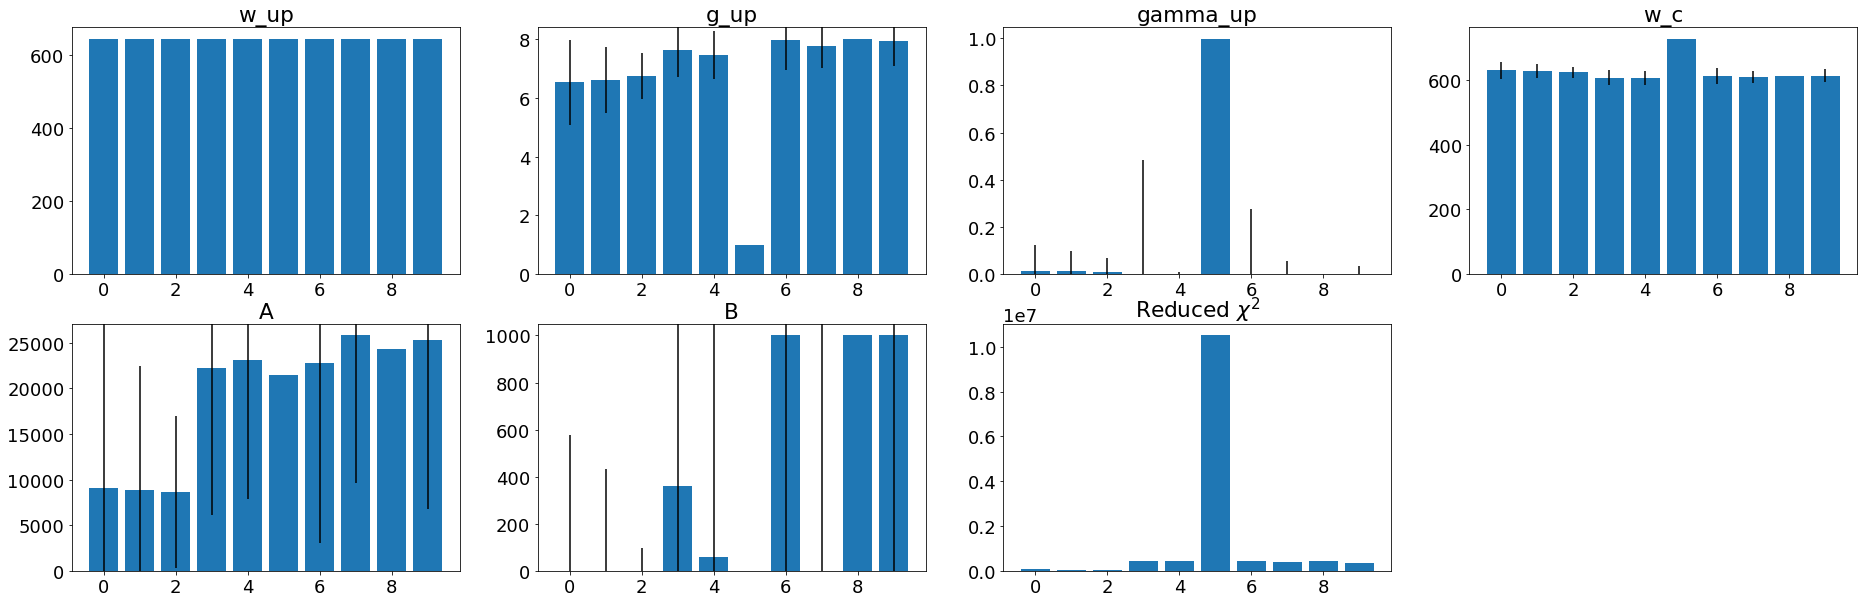

In [25]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=645, min=644, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, min=0, max=1),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=124, vary=False),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0.1, min=0, max=1000),
)
fit_params, fit_params_errors, reduced_chi = bulk_fit_siv(params)

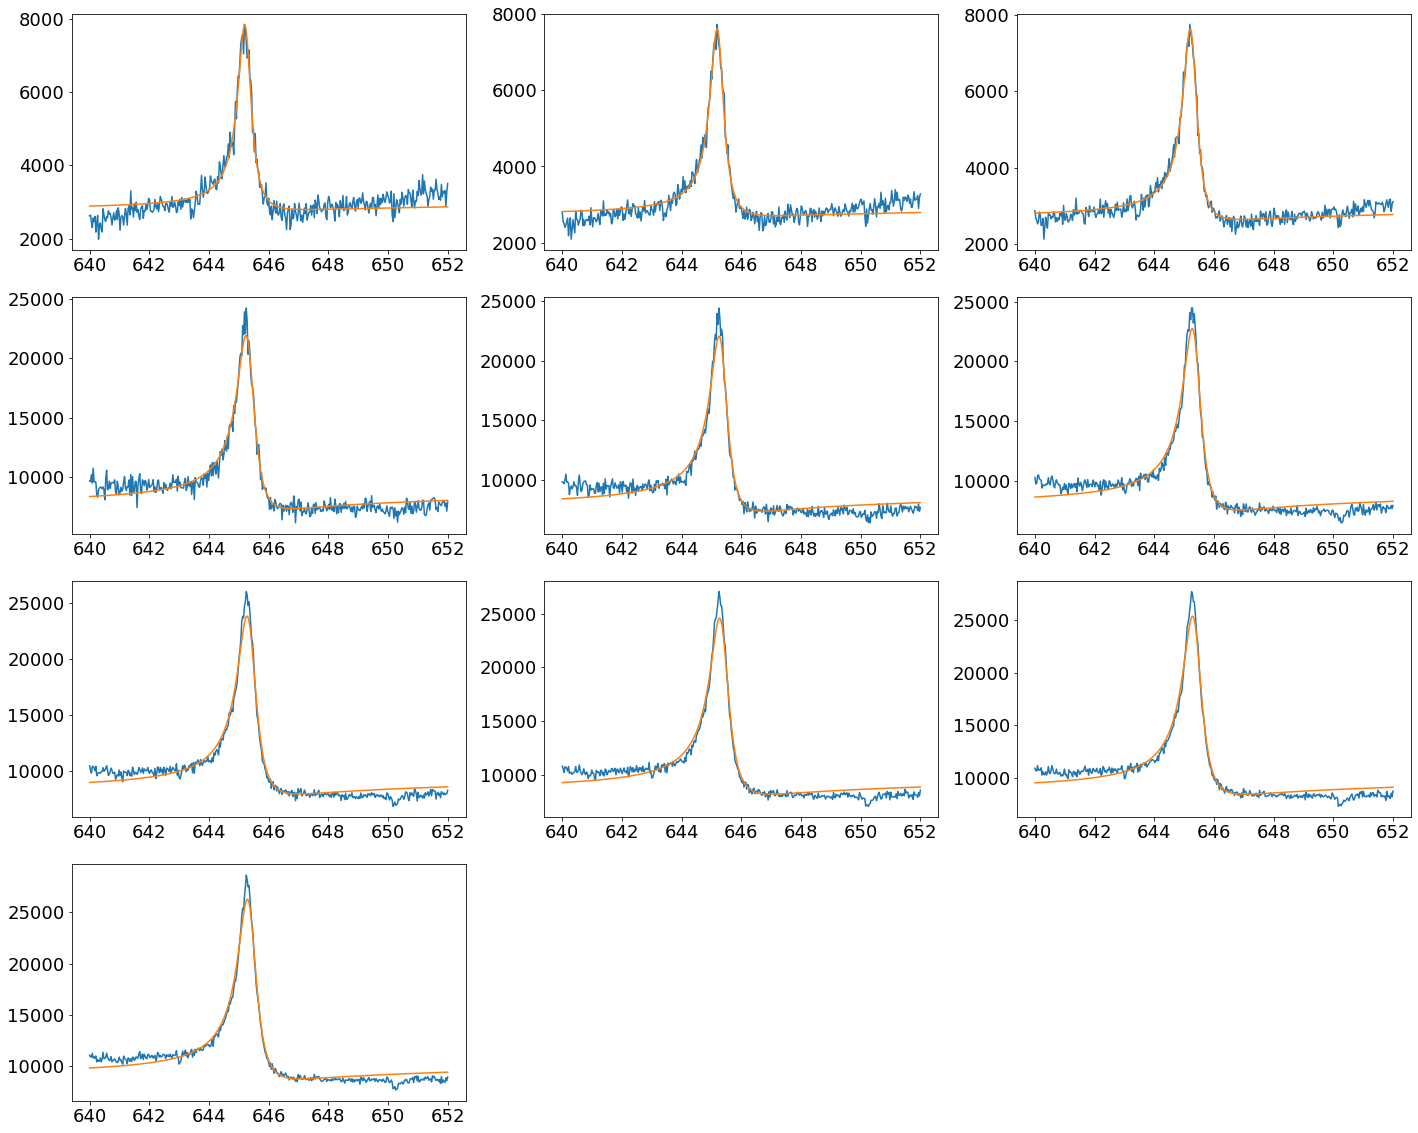

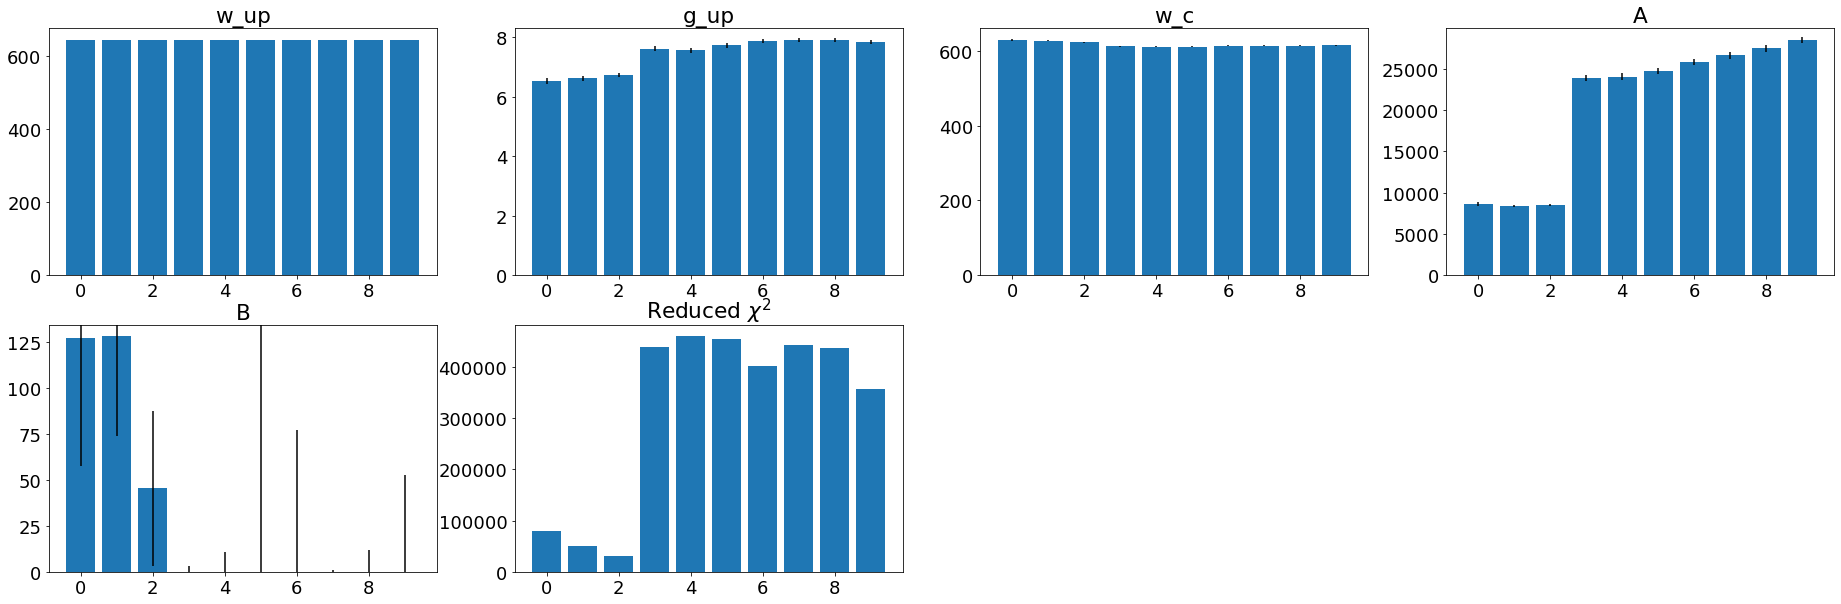

In [27]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=645, min=644, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.01, vary=False),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=124, vary=False),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0.1, min=0, max=1000),
)
fit_params, fit_params_errors, reduced_chi = bulk_fit_siv(params)

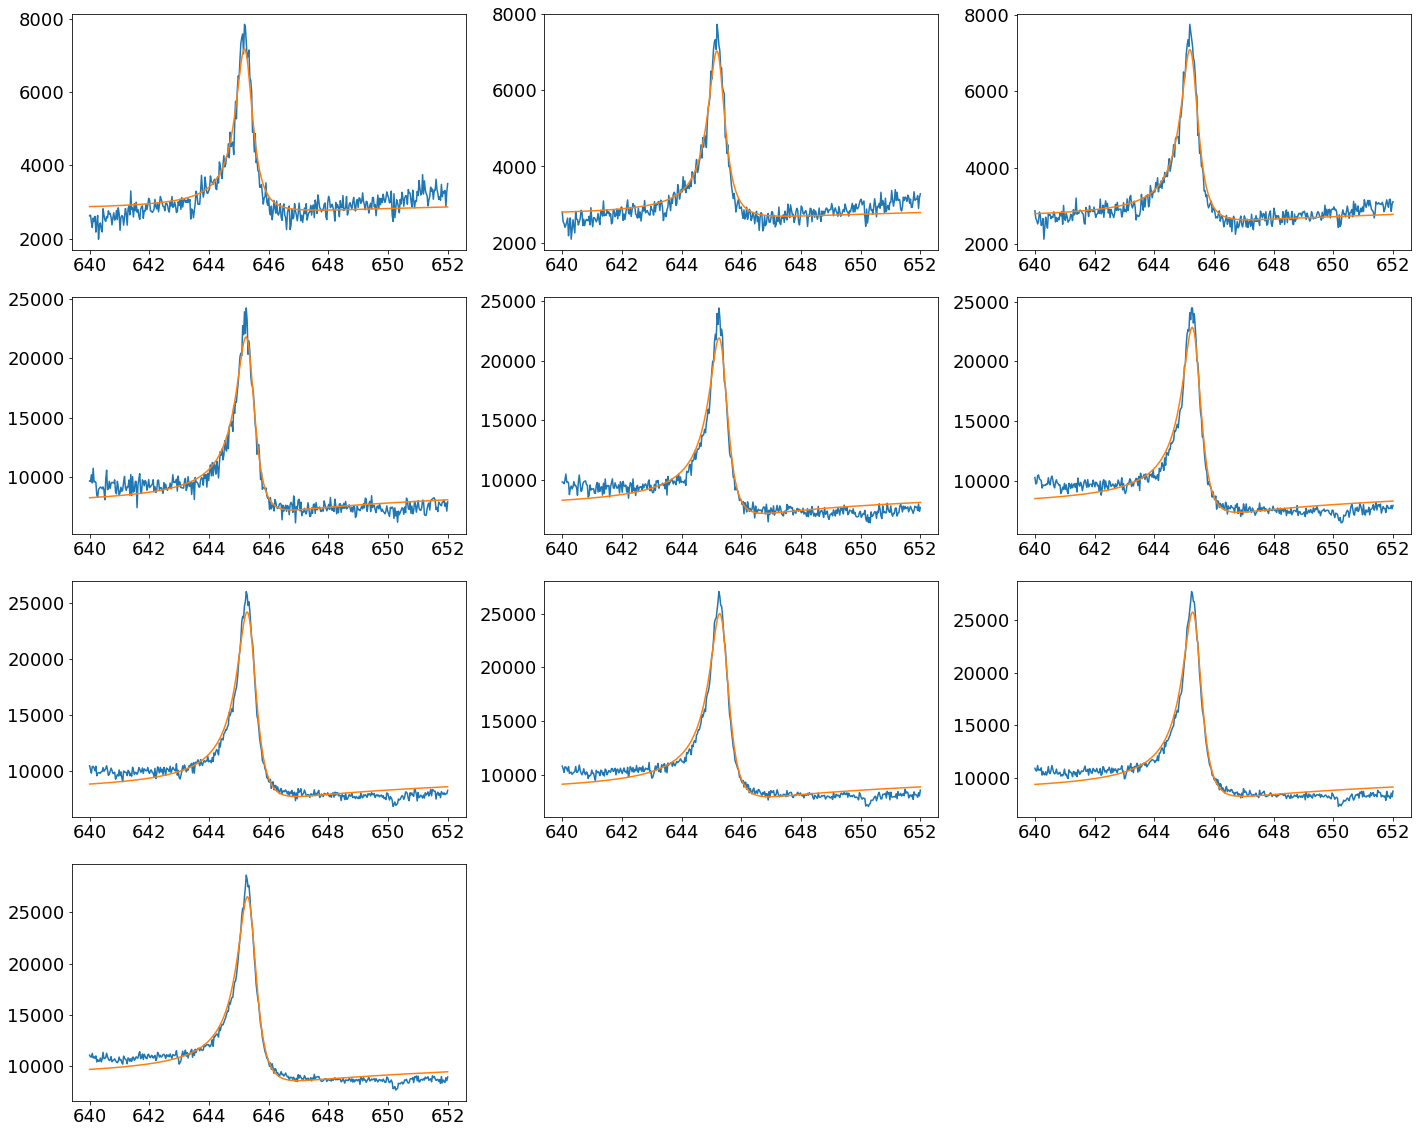

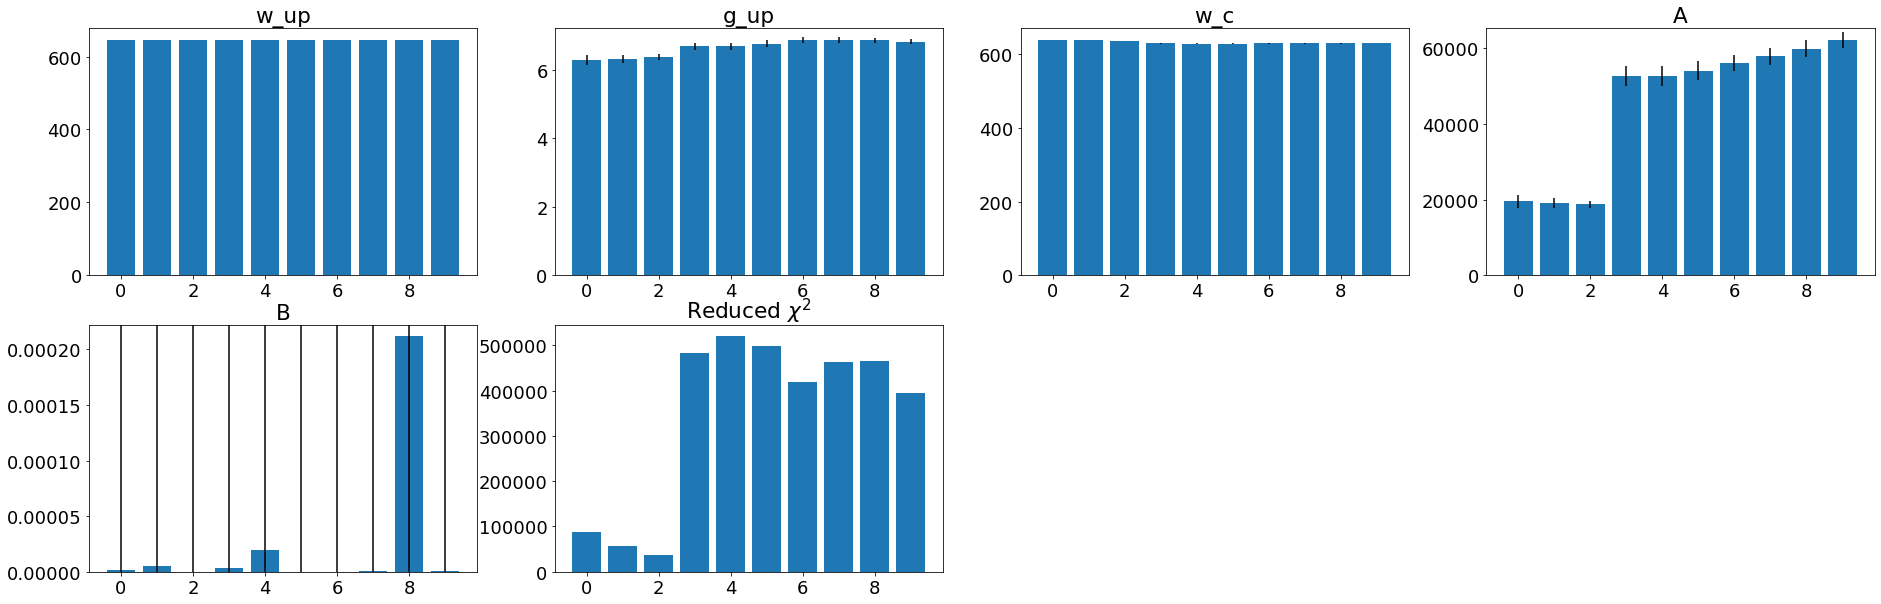

In [26]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=645, min=644, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, vary=False),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=110, vary=False),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0.1, min=0, max=1000),
)
fit_params, fit_params_errors, reduced_chi = bulk_fit_siv(params)